<img src="https://upload.wikimedia.org/wikipedia/commons/0/0e/Snowflakeschapte00warriala-p11-p21-p29-p39.jpg" height=500>Source: <a href="https://archive.org/details/snowflakeschapte00warriala">Snowflakes: a chapter from the book of nature
by Warren, Israel Perkins, 1814-1892</a>
# ATMS 511 Radation Lab: Scattering by non-spherical particles, a hands on investigation of pre-calculated scattering properties of ice crystals simulated using DDA.

Today we will be investigating the scattering characterisitcs of ice particles and aggregates from Jani Tyynel¨a Tyynel¨a J., and V. Chandrasekar (2014), Characterizing falling snow using multi-frequency dualpolarization
measurements, J. Geophys. Res. 119,8268–8283, doi:10.1002/2013JD021369 <br/>

[Link to database website](http://helios.fmi.fi/~tyynelaj/database.html)

I know this will have more of a microwave focus, but in principle you could investigate other wavelengths with new simulations of those particles

## Goals: 

The goals of this experiment are to <br/>

1) Understand how the different habits of ice affect their scatter properties.<br/>
2) Familierize you with computational coding in python (in the cloud) <br/>

### Before class you should have copied the files from my google drive directory into your own google drive. If not you can get them here: [DDA_Scatt](https://drive.google.com/drive/folders/16KIIXC-yjc4ZwM3C4hFPvQ9Y81AuRM2i?usp=sharing)



---


This first cell block imports all the packages we need to mount our drive to this Virtual Machine (This is so we can access the data to use it). <br/>

In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpokb5qhhu/pubring.gpg' created
gpg: /tmp/tmpokb5qhhu/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 18077 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.6.21-0ubuntu2_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.6.21-0ubuntu2) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.6.2

Now we have to install netCDF4 and actually mount the drive

In [4]:
#install netCDF4
!pip install netCDF4
#mount google drive to virtual machiene
!mkdir -p drive
!google-drive-ocamlfuse drive
#install pytmatrix for some functions
!pip install pytmatrix

    100% |████████████████████████████████| 5.8MB 190kB/s 
    100% |████████████████████████████████| 71kB 3.3MB/s 
  Running setup.py bdist_wheel for pytmatrix ... - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/61/4c/46/ea66cd7f1136b04e9336db867e320ace1a11adfe1864866a3e
Successfully built pytmatrix


Check to make sure your drive shows up by using the !ls command

In [8]:
!ls

Colormaps_new.py  Colormaps_new.pyc  datalab  drive


Import the packages we will need to look at the data

In [0]:
import pytmatrix
import netCDF4
import numpy as np
#plotting package
%matplotlib inline
import matplotlib.pyplot as plt

#things for colorbar activities
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
 
#for getting W-band lambda 
from pytmatrix import tmatrix_aux
from pytmatrix import tmatrix
from pytmatrix import scatter

#for reading the shape files
import pandas as pd

#setting edgecolors of the fig
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams["axes.edgecolor"] = [0,0,0]

#copy better colormap to current dir 
!cp ./drive/DDA_Scatt/Colormaps_new.py ./

#import better colormap
import Colormaps_new as cmaps

# Lab begins here:

### Why do we need to simulate so many particles? Ice comes in all different shapes and sizes:
<br>
<img src='http://www.weatherwise.org/sebin/b/n/queries-figure-3.jpg'>
<br>


### Why W-band?

If you want non-ground based observations using a conventional radar, you need a small antenna. For example, NWS radars are S-band, which have a 8.53 meter diameter antenna. Could you image?

### Examples of W-band radars: 1) Wyoming Cloud Radar, 2) Cloudsat

![Wyoming Cloud Radar](http://www.atmos.uwyo.edu/uwka/wcr/images/kawcr_7.jpg)

![Cloudsat](https://www.nasa.gov/sites/default/files/images/126766main_cloudsat-clouds-330.jpg)


### Examples of actual data: Welsh et al. 2016, Lake Effect Snow

![Welsh et al. 2016](https://journals.ametsoc.org/na101/home/literatum/publisher/ams/journals/content/mwre/2016/15200493-144.11/mwr-d-16-0057.1/20171013/images/medium/mwr-d-16-0057.1-f7.gif)

## Info on the scattering database:

The general process of the database was that for each single crystal habit type, there are 1000 particles generated within a designated size range. For these 1000 particles, the scattering properties are simulated using the DDA method. The dipoles distance is fixed to 20 microns. For more information please consult [the manual](http://helios.fmi.fi/~tyynelaj/Tyynela_scatdb_manual.pdf) <br>

The scattering database supplies the following: 

1) Cross-sections (Scattering,Extinction and radar ones) <br>
2) Phase Function <br>
3) Physical (e.g. particle diameter) <br>


### Notes on orientation:
Depending on the particles you are interested in some have preferential patterns in which they fall. 

<br>
<br>

For the calculations done here, the **single particles** are oriented following *"... Noel and Sassen (2005) for warmer clouds, which indicate highly horizontal orientation
with an average canting angle of about 2 degrees and a Gaussian distribution with a standard deviation of 1 degree"*

<br>
<br>

**Aggregates** are assumed to be randomly oriented *" .. random orientation and a narrow Gaussian size distribution for the ice crystals
in an aggregate because of the complex flow around the snowflakes."* 

For example of how snowflakes fall see the video below:

[Snowflakes/Nesbitt](https://www.facebook.com/swnesbitt/videos/vb.100011320111447/515293298858003/?type=3)

Aggregates will flutter and rotate as they fall, thus an assumption of random orientation is plausable. 

<br>
<br>

In the files for single particles the calculations are done for various 'elevation angles' (will be drawn on board), but these values are 0. I emailed the owner and he is investigating. Luckily there is still data for the 90 degree elevation angle. 

### The coding portion of the lab starts now:

The function below just loads in all the seperate files (one for each of the three listed) into one file for convenience. ***You will have to change the path to your drive path***

In [0]:
def sep_to_dict(crystal_name='hexcolum_crystal'):
  
  """
  
  This function loads in the 3 files into one dictionary
  
  crystal_name: str from filename 
 
  """
  
  #for your own personal drive you will have to make sure this path is correct
  flname1 = './drive/DDA_Scatt/DDA_Tyynela/Cross/Tyynela_090216_cross_W_'
  flname1 = flname1 + crystal_name + '.nc' 
  
  
  flname2 = './drive/DDA_Scatt/DDA_Tyynela/Phys/Tyynela_240614_phys_'
  flname2 = flname2 + crystal_name + '.nc' 
  
  flname3 = './drive/DDA_Scatt/DDA_Tyynela/Phase/Tyynela_090216_phase_W_'
  flname3 = flname3 + crystal_name + '.nc' 
  
  #define empty dict. 
  data = {}
  
  #read netCDF files
  data['cross'] =  netCDF4.Dataset(flname1,'r')
  data['phys'] = netCDF4.Dataset(flname2,'r')
  data['phase'] = netCDF4.Dataset(flname3,'r')
  
  #load in shape files of random particles
  if crystal_name == 'hexplate_crystal':
    data['shape'] = pd.read_csv('./drive/DDA_Scatt/DDA_Tyynela/Shape/ice_hexplate_aggregate0881_nc001_dd20_uniform.shape',header=None,delimiter=' ')
  elif crystal_name == 'steldend_crystal':
    data['shape'] = pd.read_csv('./drive/DDA_Scatt/DDA_Tyynela/Shape/ice_steldend_aggregate0888_nc001_dd20_uniform.shape',header=None,delimiter=' ')
  elif crystal_name == 'steldend_aggregate':
    sub_d = {}
    sub_d[0] = pd.read_csv('./drive/DDA_Scatt/DDA_Tyynela/Shape/ice_steldend_aggregate0059_nc002_dd20_lam0500.shape',header=None,delimiter=' ')
    sub_d[1] = pd.read_csv('./drive/DDA_Scatt/DDA_Tyynela/Shape/ice_steldend_aggregate0010_nc010_dd20_lam0500.shape',header=None,delimiter=' ')
    sub_d[2] = pd.read_csv('./drive/DDA_Scatt/DDA_Tyynela/Shape/ice_steldend_aggregate0080_nc020_dd20_lam0500.shape',header=None,delimiter=' ')
    sub_d[3] = pd.read_csv('./drive/DDA_Scatt/DDA_Tyynela/Shape/ice_steldend_aggregate0026_nc030_dd20_lam0500.shape',header=None,delimiter=' ')
    sub_d[4] = pd.read_csv('./drive/DDA_Scatt/DDA_Tyynela/Shape/ice_steldend_aggregate0083_nc040_dd20_lam0500.shape',header=None,delimiter=' ')
    sub_d[5] = pd.read_csv('./drive/DDA_Scatt/DDA_Tyynela/Shape/ice_steldend_aggregate0088_nc050_dd20_lam0500.shape',header=None,delimiter=' ')
    data['shape'] = sub_d
  
  #save particle name for titles
  data['particle_name'] = crystal_name
  
  return data

In [0]:
hex_col = sep_to_dict(crystal_name='hexcolum_crystal')
hex_pla = sep_to_dict(crystal_name='hexplate_crystal')
needle = sep_to_dict(crystal_name='needle_crystal')
dendrite = sep_to_dict(crystal_name='steldend_crystal')

# Question 1: Let us investigate the Phase Function for the various habits of ice at W-band. 

This scattering database gives us the normalized scattering function which is defined in the [manual section 3.3](http://helios.fmi.fi/~tyynelaj/Tyynela_scatdb_manual.pdf)

For brevity and your sanity, I have coded up some functions. But I have commented them extensivley

In [0]:
def phase_plot(crystal_dict):
  
  """
  
  This function takes the DDA phase function data and plots it on a 2d graph as
  a function of scattering angle. 
  
  """
  
  #Make figure
  fig = plt.figure(figsize=(10, 5))
  #get axis handle 
  ax = plt.gca()
  #set axes for colorbar
  ax1 = fig.add_axes([0.075, -0.05, 0.9, 0.05])
  
  #get a colormap to color the lines by the size parameter
  #jet = plt.get_cmap('viridis') 
  jet = cmaps.parula
  
  #Calculate the size parameter for each particle (1000 single crystals)
  x = 2*np.pi*(crystal_dict['phys']['dmax'][:]/2.)/(tmatrix_aux.wl_W/1000.)
  
  #normalize the colormap between the max and min of x
  cNorm  = colors.Normalize(vmin=x.min(), vmax=x.max())
  scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

  #loop across all particles that were simulated 
  for i in np.arange(0,1000):
    #get variable for color choice
    particle_choice = x[i]
    #get color
    colorVal = scalarMap.to_rgba(particle_choice)
    #plot phase function line
    ax.plot(np.arange(0,181,1),crystal_dict['phase']['phasefunc'][:,6,i],color=colorVal,alpha=0.5)
  
  #set labels
  ax.set_xlabel('$\Theta$ $[\degree]$')
  ax.set_ylabel('Normalized Phase Func')
  ax.set_title(crystal_dict['particle_name']+ ' at 94GHz')
  #
  
  #For inset:
  
  #Each of the crystals have just one shape file randomly chosen for an example
  if crystal_dict['particle_name'] == 'hexplate_crystal':
    #add inset for image
    left, bottom, width, height = [0.65, 0.6, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    #plot scatterplot of all dipoles
    ax2.scatter(crystal_dict['shape'][0],crystal_dict['shape'][1],color='k',s=1)
    #turn off axis labels
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    #zoom out alittle
    ax2.set_xlim([crystal_dict['shape'][0].min()-10,crystal_dict['shape'][0].max()+10])
    ax2.set_ylim([crystal_dict['shape'][1].min()-10,crystal_dict['shape'][1].max()+10])
    
  elif crystal_dict['particle_name'] == 'steldend_crystal':
    left, bottom, width, height = [0.65, 0.6, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.scatter(crystal_dict['shape'][0],crystal_dict['shape'][1],color='k',s=1)
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    ax2.set_xlim([crystal_dict['shape'][0].min()-10,crystal_dict['shape'][0].max()+10])
    ax2.set_ylim([crystal_dict['shape'][1].min()-10,crystal_dict['shape'][1].max()+10])
    
  elif crystal_dict['particle_name'] == 'steldend_aggregate':
    left, bottom, width, height = [0.65, 0.6, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.scatter(crystal_dict['shape'][0],crystal_dict['shape'][1],color='k',s=1)
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    ax2.set_xlim([crystal_dict['shape'][0].min()-10,crystal_dict['shape'][0].max()+10])
    ax2.set_ylim([crystal_dict['shape'][1].min()-10,crystal_dict['shape'][1].max()+10])
  
  #fill colorbar
  cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=jet,
                                  norm=cNorm,
                                  orientation='horizontal')
  cb1.set_label('X')
  
  plt.show()
  
  return

def phase_polar(crystal_dict):
  
  """
  
  This function takes the DDA phase function data and plots it on a polar plot
  
  """
  
  #make figure
  fig = plt.figure(figsize=(10, 5))
  #get axis handle
  ax = plt.gca()
  
  #add colorbar axis
  ax1 = fig.add_axes([0.075, -0.05, 0.9, 0.05])
  
  #get colorscale
  #jet = cm = plt.get_cmap('viridis') 
  jet = cmaps.parula
  
  #calculate x
  x = 2*np.pi*(crystal_dict['phys']['dmax'][:]/2.)/(tmatrix_aux.wl_W/1000.)
  
  #normalize colorscale to x
  cNorm  = colors.Normalize(vmin=x.min(), vmax=x.max())
  scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
  
  #loop across particles
  for i in np.arange(0,1000):
    #get value for color
    particle_choice = x[i]
    #get color
    colorVal = scalarMap.to_rgba(particle_choice)
    
    #plot 0 --> 180
    plt.polar(np.arange(0,181,1)*np.pi/180.,crystal_dict['phase']['phasefunc'][:,6,i],color=colorVal,alpha=0.5)
    #plot 180 -> 360
    plt.polar(-np.arange(0,181,1)*np.pi/180.,crystal_dict['phase']['phasefunc'][:,6,i],color=colorVal,alpha=0.5)

  #add title
  plt.title(crystal_dict['particle_name']+ ' at 94GHz')

  #fill colorbar
  cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=jet,
                                  norm=cNorm,
                                  orientation='horizontal')
  cb1.set_label('X')

  plt.show()
  
  return

# Lets look at the hexagonal plate first:

The functions should provide a graph with the phase function on the y-axis and the scattering angle on the x-axis. The color axis will be the size parameter. All 1000 particles are shown. <br>

Like I said before the only elevation angle we have is 90 degrees. So envision a radar stairing straight up. Like this picture of the magnificent S-band Chilbolton radar:

![Chilbolton](https://farm4.staticflickr.com/3577/5777441228_f49623e9c5_z.jpg)


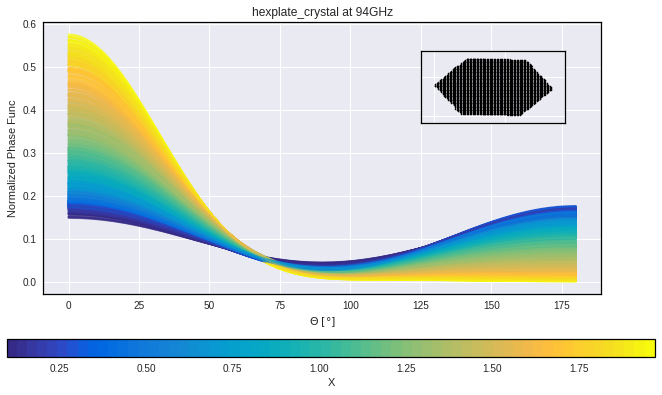

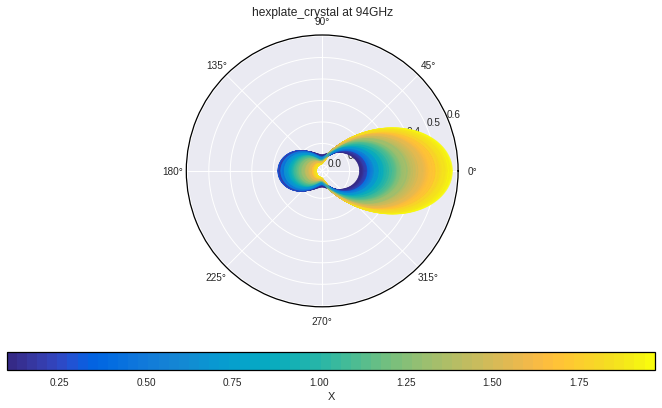

In [21]:
#it is really quite simple to run the function, just send in the dict.
phase_plot(hex_pla)
phase_polar(hex_pla)

# Q1a: Looking at the above plots discuss the scattering of a hexagonal plate at W-band:


Enter answer here (double click)

# Sticking with the planar crystal regime, lets do a dendrite:

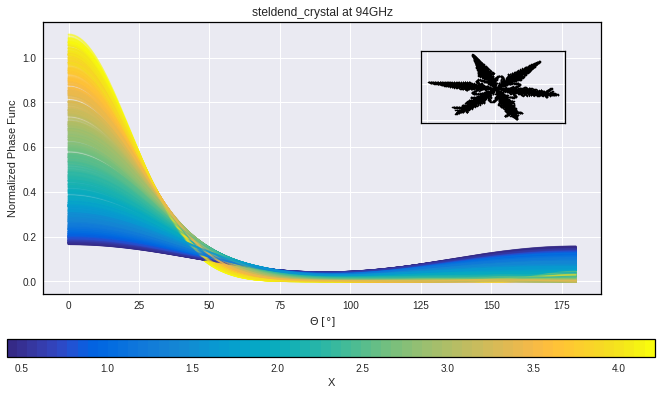

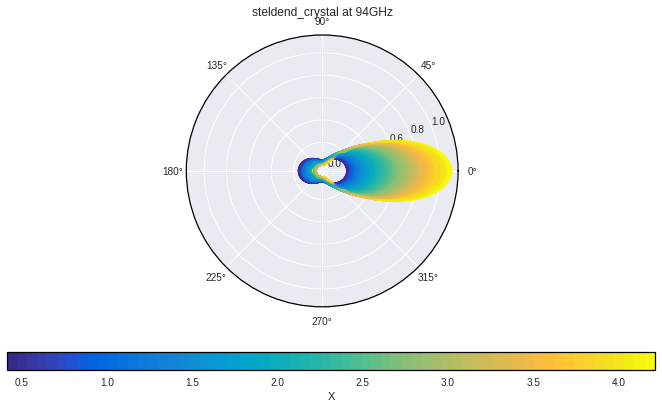

In [22]:
phase_plot(dendrite)
phase_polar(dendrite)

# Q1b: Looking at the above plots discuss the scattering of a dendrite at W-band:


Enter answer here (double click)

# Question 2: Let's look compare these two crystal types. It should be interesting how we go from a solid plate to a more sparse dendrite. 

To do this we should consider the same sizes. To do this we should average over some size range. Lets do 1.4 to 1.5 mm 

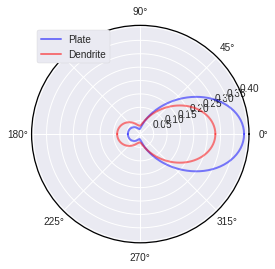

In [27]:
#make arrays for maximum dimension
d_plate = hex_pla['phys']['dmax'][:]
d_dendrite = dendrite['phys']['dmax'][:]

#search for particles 1.4 to 1.5 mm 
ind1 = np.where(d_plate*1000. >= 1.4)
ind2 = np.where(d_plate*1000. <= 1.5)
ind3 = np.intersect1d(ind1,ind2)
#average the phase function just across those
phase_av_plate = np.mean(hex_pla['phase']['phasefunc'][:,6,ind3],axis=1)

#same for the dendrite
ind1 = np.where(d_dendrite*1000. >= 1.4)
ind2 = np.where(d_dendrite*1000. <= 1.5)
ind3 = np.intersect1d(ind1,ind2)
phase_av_dendrite = np.mean(dendrite['phase']['phasefunc'][:,6,ind3],axis=1)

#plot the polar plots
plt.polar(np.arange(0,181,1)*np.pi/180.,phase_av_plate,color='b',alpha=0.5,lw=2,label='Plate')
plt.polar(-np.arange(0,181,1)*np.pi/180.,phase_av_plate,color='b',alpha=0.5,lw=2)
plt.polar(np.arange(0,181,1)*np.pi/180.,phase_av_dendrite,color='r',alpha=0.5,lw=2,label='Dendrite')
plt.polar(-np.arange(0,181,1)*np.pi/180.,phase_av_dendrite,color='r',alpha=0.5,lw=2)
plt.legend(loc=2,frameon=True,framealpha=1)
plt.show()

# What do we see here? 

Why do we see a difference? 

Enter answer here (double click)

# Question 3: Lets look at the other scattering properties of these partiles. Plot up the cross-sections of the particles

The scatter cross sections, and the asym parameter. They can be found in the 'cross' key of the dict. 

In [28]:
hex_pla['cross'].variables.keys()

[u'chh', u'cvv', u'cvh', u'crr', u'crl', u'csca', u'cabs', u'cext', u'asym']

The ones we are interested in are csca and asym. As a function of X

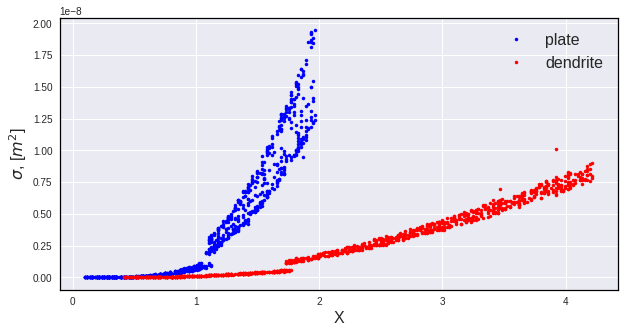

In [44]:
plt.figure(figsize=(10,5))

x = 2*np.pi*(hex_pla['phys']['dmax'][:]/2.)/(tmatrix_aux.wl_W/1000.)
x2 = 2*np.pi*(dendrite['phys']['dmax'][:]/2.)/(tmatrix_aux.wl_W/1000.)

plt.plot(x,hex_pla['cross']['csca'][6,:],'b.',label='plate')
plt.plot(x2,dendrite['cross']['csca'][6,:],'r.',label='dendrite')
plt.xlabel('X',fontsize=16)
plt.ylabel(r'$\sigma$, [$m^2$]',fontsize=16)
plt.legend(fontsize=16)

### Calculating Q get's trickier with these non-geometric shapes. Luckily, the geometric cross-section of the particle is included!

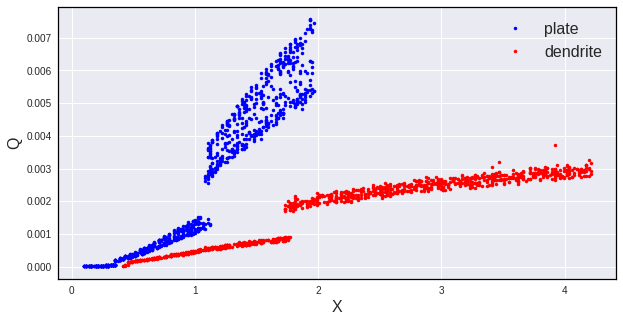

In [43]:
#plot Q's

plt.figure(figsize=(10,5))

Q_sca_pla = hex_pla['cross']['csca'][6,:]/hex_pla['phys']['area'][:]
Q_sca_den = dendrite['cross']['csca'][6,:]/dendrite['phys']['area'][:]
plt.plot(x,Q_sca_pla,'b.',label='plate')
plt.plot(x2,Q_sca_den,'r.',label='dendrite')
plt.xlabel('X',fontsize=16)
plt.ylabel(r'Q',fontsize=16)
plt.legend(fontsize=16)

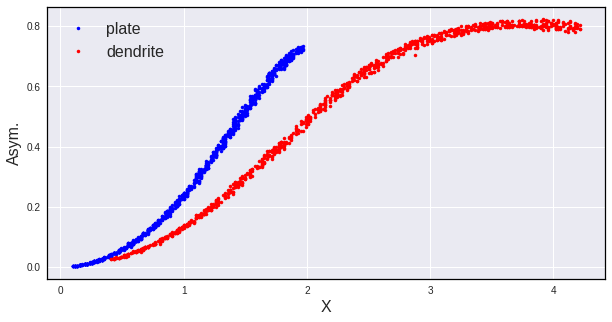

In [30]:
plt.figure(figsize=(10,5))
plt.plot(x,hex_pla['cross']['asym'][6,:],'b.',label='plate')
plt.plot(x2,dendrite['cross']['asym'][6,:],'r.',label='dendrite')

plt.xlabel('X',fontsize=16)
plt.ylabel(r'Asym.',fontsize=16)
plt.legend(fontsize=16)

## Let's compare the DDA calculations to the t-matrix and MIE. 
Let's assume the ice is at 0 deg C, so then:

from some matlab code:

m = 1.7856 + 0.0023i

In [0]:
x = 2*np.pi*(hex_pla['phys']['dmax'][:]/2.)/(tmatrix_aux.wl_W/1000.)
x2 = 2*np.pi*(dendrite['phys']['dmax'][:]/2.)/(tmatrix_aux.wl_W/1000.)

r = (hex_pla['phys']['dmax'][:]/2.)
lam = tmatrix_aux.wl_W/1000.
m = complex(1.7856,0.0023)

#code from Wednesday
scat_obs = np.zeros(len(r),dtype=object)
scat_obs2 = np.zeros(len(r),dtype=object)

for i in np.arange(0,len(r)):
    t =  tmatrix.Scatterer(thet0=0,m=m,wavelength=lam,radius=r[i],shape=tmatrix.Scatterer.SHAPE_SPHEROID,axis_ratio=1)
    t.radius_type = t.RADIUS_MAXIMUM
    scat_obs[i] = t
    
    t =  tmatrix.Scatterer(thet0=0,m=m,wavelength=lam,radius=r[i],shape=tmatrix.Scatterer.SHAPE_SPHEROID,axis_ratio=1/0.6)
    t.radius_type = t.RADIUS_MAXIMUM
    scat_obs2[i] = t

sigma_s = np.zeros(len(r))
sigma_e = np.zeros(len(r))
sigma_s2 = np.zeros(len(r))
sigma_e2 = np.zeros(len(r))
for i in np.arange(0,len(r)):
    sigma_s[i] = pytmatrix.scatter.sca_xsect(scat_obs[i])
    sigma_e[i] = pytmatrix.scatter.ext_xsect(scat_obs[i])
    sigma_s2[i] = pytmatrix.scatter.sca_xsect(scat_obs2[i])
    sigma_e2[i] = pytmatrix.scatter.ext_xsect(scat_obs2[i])
#

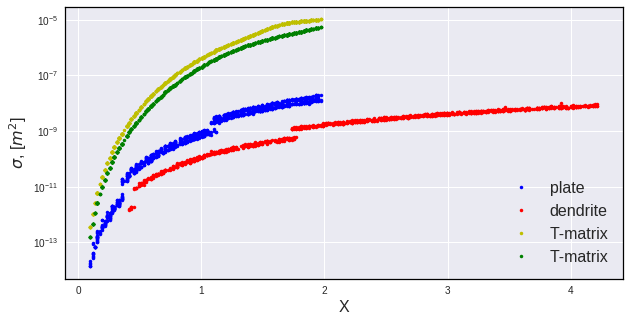

In [65]:
plt.figure(figsize=(10,5))

plt.plot(x,hex_pla['cross']['csca'][6,:],'b.',label='plate')
plt.plot(x2,dendrite['cross']['csca'][6,:],'r.',label='dendrite')
plt.plot(x,sigma_s,'.y',label='T-matrix')
plt.plot(x,sigma_s2,'.g',label='T-matrix')
plt.semilogy()
plt.xlabel('X',fontsize=16)
plt.ylabel(r'$\sigma$, [$m^2$]',fontsize=16)
plt.legend(fontsize=16)

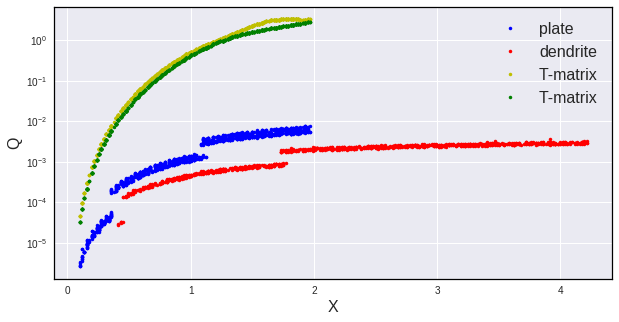

In [68]:
#plot Q's

plt.figure(figsize=(10,5))

Q_sca_pla = hex_pla['cross']['csca'][6,:]/hex_pla['phys']['area'][:]
Q_sca_den = dendrite['cross']['csca'][6,:]/dendrite['phys']['area'][:]
plt.plot(x,Q_sca_pla,'b.',label='plate')
plt.plot(x2,Q_sca_den,'r.',label='dendrite')
plt.plot(x,sigma_s/(np.pi*r**2),'y.',label='T-matrix')
plt.plot(x,sigma_s2/(0.6*np.pi*r**2),'g.',label='T-matrix')
plt.semilogy()
plt.xlabel('X',fontsize=16)
plt.ylabel(r'Q',fontsize=16)
plt.legend(fontsize=16)

# Discuss your results:

Enter answer here (double click)

# That was the scattering propeties of 1 crystal at a time. You might be asking yourself: 'Self: what about aggregates? those happen, how does this affect the scattering?'. Good question! Lets investigate



---

The aggregates come in a slightly different format. Now we have various numbers of monomers to the aggergate (aka how many individual dendrites make up the aggergate). 

The number of monomers is as follows:

0) 2 <br>
1) 10 <br>
2) 20 <br>
3) 30 <br>
4) 40 <br>
5) 50 <br>

Lucky for you, again I have already supplied the function to investigate the phase function!

In [0]:
#load the aggs 
den_agg = sep_to_dict(crystal_name='steldend_aggregate')


#have to make new funtions 

def phase_plot2(crystal_dict,index):

  fig = plt.figure(figsize=(10, 5))
  ax = plt.gca()
  ax1 = fig.add_axes([0.075, -0.05, 0.9, 0.05])

  #jet = cm = plt.get_cmap('viridis') 
  jet = cmaps.parula
  
  x = 2*np.pi*(crystal_dict['phys']['dmax'][:,index]/2.)/(tmatrix_aux.wl_W/1000.)

  cNorm  = colors.Normalize(vmin=x.min(), vmax=x.max())
  scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

  for i in np.arange(0,100):
    particle_choice = x[i]
    colorVal = scalarMap.to_rgba(particle_choice)
    ax.plot(np.arange(0,181,1),crystal_dict['phase']['phasefunc'][:,index,i],color=colorVal,alpha=0.5)

  ax.set_xlabel('$\Theta$ $[\degree]$')
  ax.set_ylabel('Normalized Phase Func')
  ax.set_title(crystal_dict['particle_name']+ ' at 94GHz')
    
  if crystal_dict['particle_name'] == 'steldend_aggregate':
    left, bottom, width, height = [0.65, 0.6, 0.2, 0.2]
    ax2 = fig.add_axes([left, bottom, width, height])
    ax2.scatter(crystal_dict['shape'][index][0],crystal_dict['shape'][index][1],color='k',s=1)
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    ax2.set_xlim([crystal_dict['shape'][index][0].min()-10,crystal_dict['shape'][index][0].max()+10])
    ax2.set_ylim([crystal_dict['shape'][index][1].min()-10,crystal_dict['shape'][index][1].max()+10])
    
  cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmaps.parula,
                                  norm=cNorm,
                                  orientation='horizontal')
  cb1.set_label('X')
  
  plt.show()
  
  return

def phase_polar2(crystal_dict,index):
  fig = plt.figure(figsize=(10, 5))
  ax = plt.gca()
  ax1 = fig.add_axes([0.075, -0.05, 0.9, 0.05])

  #jet = cm = plt.get_cmap('viridis') 
  jet = cmaps.parula
  
  x = 2*np.pi*(crystal_dict['phys']['dmax'][:,index]/2.)/(tmatrix_aux.wl_W/1000.)

  cNorm  = colors.Normalize(vmin=x.min(), vmax=x.max())
  scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

  for i in np.arange(0,100):
    particle_choice = x[i]
    colorVal = scalarMap.to_rgba(particle_choice)
    plt.polar(np.arange(0,181,1)*np.pi/180.,crystal_dict['phase']['phasefunc'][:,index,i],color=colorVal,alpha=0.5)
    plt.polar(-np.arange(0,181,1)*np.pi/180.,crystal_dict['phase']['phasefunc'][:,index,i],color=colorVal,alpha=0.5)

  plt.title(crystal_dict['particle_name']+ ' at 94GHz')


  cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmaps.parula,
                                  norm=cNorm,
                                  orientation='horizontal')
  cb1.set_label('X')

  plt.show()
  
  return

# Question 4: Investigate the difference in the phase function for 1 dendrite, agg. with 2 dendrites ... on to 50 dendrites

Like we did for question 2. 

But before we get to far into it lets just look at the phase function of these aggs

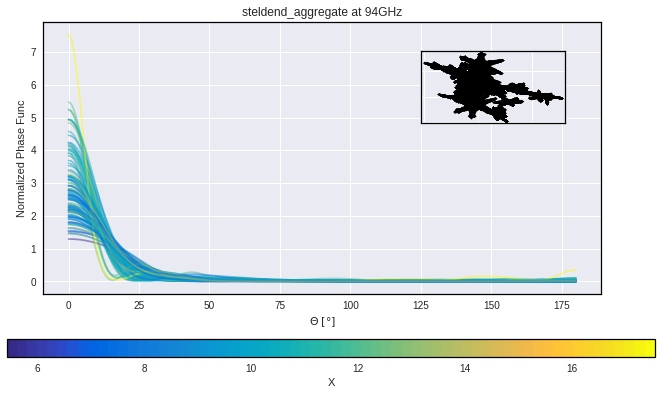

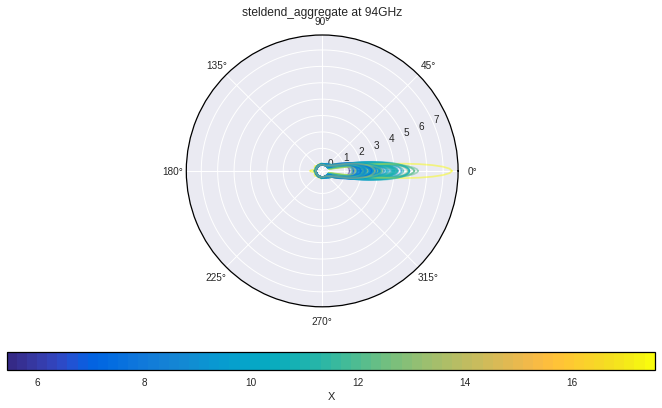

In [50]:
i = 5
phase_plot2(den_agg,i)
phase_polar2(den_agg,i)

# Q4a: Write down some obs looking through these

Enter answer here (double click)

# Q5: Repeat Q2 but now for the dendrite and various aggergates

Write down some expectations:

#### It should be straight forward that as we add monomers the particle is going to get larger. If we want to make something like Q2, we will have to limit our size to something that fits close to the singal one. To figure this out we will use a boxplot. Play around with the index to see where we have overlap 

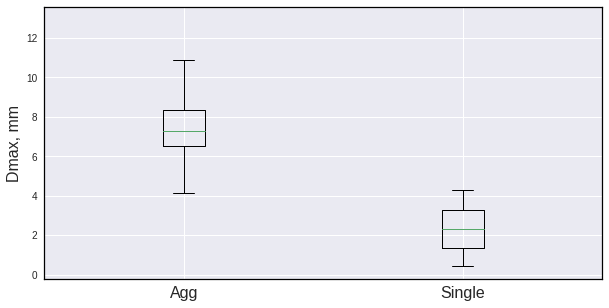

In [173]:
index = 3

plt.figure(figsize=(10,5))
plt.boxplot([d_agg[:,index]*1000,d_dendrite*1000])
plt.ylabel('Dmax, mm',fontsize=16)
ax = plt.gca()
ax.xaxis.set_ticklabels(['Agg','Single'],fontsize=16)
plt.show()

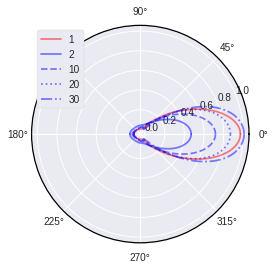

In [203]:
d_agg= den_agg['phys']['dmax'][:]
d_dendrite = dendrite['phys']['dmax'][:]

ind1 = np.where(d_dendrite*1000. >= 3.5)
ind2 = np.where(d_dendrite*1000. <= 4.5)
ind3 = np.intersect1d(ind1,ind2)
phase_av_dendrite = np.mean(dendrite['phase']['phasefunc'][:,6,ind3],axis=1)
plt.polar(np.arange(0,181,1)*np.pi/180.,phase_av_dendrite,color='r',alpha=0.5,label='1')
plt.polar(-np.arange(0,181,1)*np.pi/180.,phase_av_dendrite,color='r',alpha=0.5)

ls_a = ['-','--',':','-.']
label = ['2','10','20','30']
for a in np.arange(0,4):
  ind1 = np.where(d_agg[:,a]*1000. >= 3.5)
  ind2 = np.where(d_agg[:,a]*1000. <= 4.5)
  ind3 = np.intersect1d(ind1,ind2)
  phase_av_agg= np.mean(den_agg['phase']['phasefunc'][:,a,ind3],axis=1)
  plt.polar(np.arange(0,181,1)*np.pi/180.,phase_av_agg,color='b',alpha=0.5,ls=ls_a[a],label=label[a])
  plt.polar(-np.arange(0,181,1)*np.pi/180.,phase_av_agg,color='b',alpha=0.5,ls=ls_a[a])


plt.legend(loc=2,frameon=True,framealpha=1)
plt.show()

## Is this what you were anticipating? 


---

Discuss below

Enter answer here (double click)

# Depending on time we can investigate another frequency (S-band). 

# Concluding remarks:


# Congrats! 

This concludes non-spherical scattering.